<a href="https://colab.research.google.com/github/Keenandrea/attention-is-all-you-need-analysis/blob/master/presentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Attention Is All You Need, Or The Transformer

---

**Keenan Andrea**, Student of Computer Science at *UMSL*, knnwllmndr@gmail.com

---

## Abstract
The research addressed by this paper proposes a new  network architecture: the Transformer, which does away with recurrence and convolutions entirely, rather assembling the network solely on attention mechanisms. By doing just that, the Transformer achieves parallelization of sequences by replacing recurrence with attention and encoding the symbol position in sequence, which, in turn, leads to dramatically shorter training time. Moreover, sequential computation is reduced to constant *O*(1) operations taken to learn the dependency between two symbols regardless of the distance between their sequence positions. These are claims made and backed by experiments on two machine translation tasks, conclusively showing that the Transformer establishes single-model state-of-the-art results with English constituency and may also be successfully applied to other tasks.

---

##1 Introduction
In a nutshell, the Transformer architecture aims at the problem of sequence transduction, meaning any task where input sequences are transformed into output sequences. These tasks employ a humongous number of sequences, are laborious, and negatively affect the training time. The goal of the Transformer is to design a single framework to handle as many sequences as possible.

---

## 2 Model Architecture
Encoder-decoder models have proven successful in neural sequence transduction. In the Transformer, both the encoder and the decoder are stacks composed of identical layers, with the decoder stacked directly on top of the encoder. The encoder maps an input sequence of symbol representations to a sequence of continuous representations. Once these continuous representations are defined, the decoder then generates an output sequence of symbols one element at a time. Let's take a look:


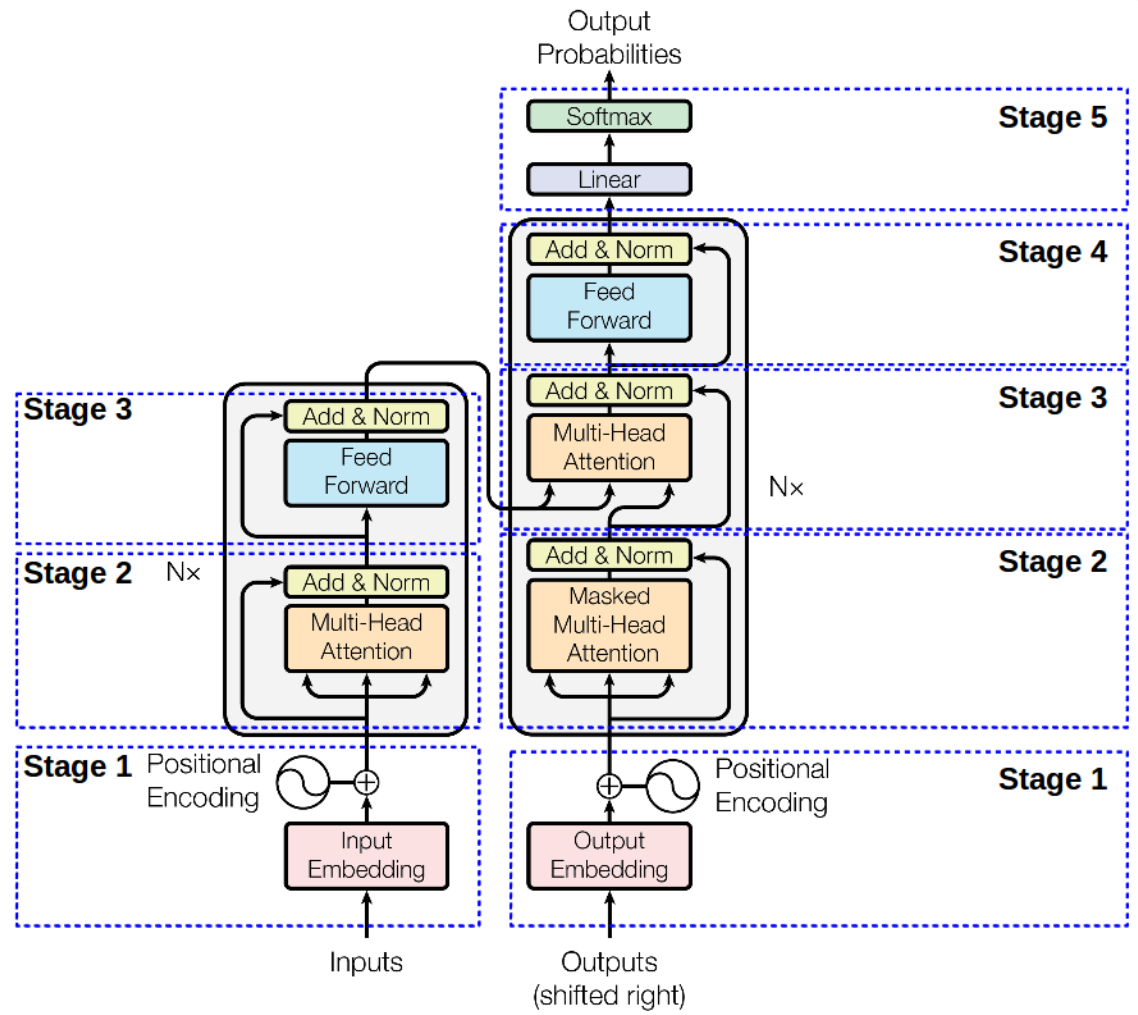

In [19]:
from IPython.display import Image
Image('transformer_model.PNG', width=800, height=650)

## 2.1 Encoder
An important part of the model is the information on sequence ordering. Each token in a sequence is represented by positional encodings. Encoder input is positional encodings added to embedded inputs. The encoder itself is composed of a stack of N = 6, or more than six, identical layers. Each layered stack pictured above is composed out of a multi-head self-attention sub-layer, and a point-wise or scaled dot-product sub-layer. 

In addition, residual connections, which allow gradients to flow through a network directly, without passing through non-linear activation functions that cause exploding- or vanishing-gradients, are employed around each of the two sub-layers, followed by layer normalization, which normalizes the inputs across the input features.

In [0]:
from IPython.display import Image
Image('scaled_dot_attention.PNG', width=425, height=500)

### 2.1.1 Scaled Dot Product Attention
The first sub-layer of the encoder is a particular attention called Scaled Dot-Product Attention. The input consists of queries and keys (*Q, K*), and values (*V*). The dot products of a query are computed with all keys, then each is divided by the square-root of this computation, and finally a softmax function is applied to obtain the weights on the values.

The attention function simultaneously  computes on a set of queries, packed together into a matrix *Q*. The keys and values are also packed together into matrices *K* and *V*.

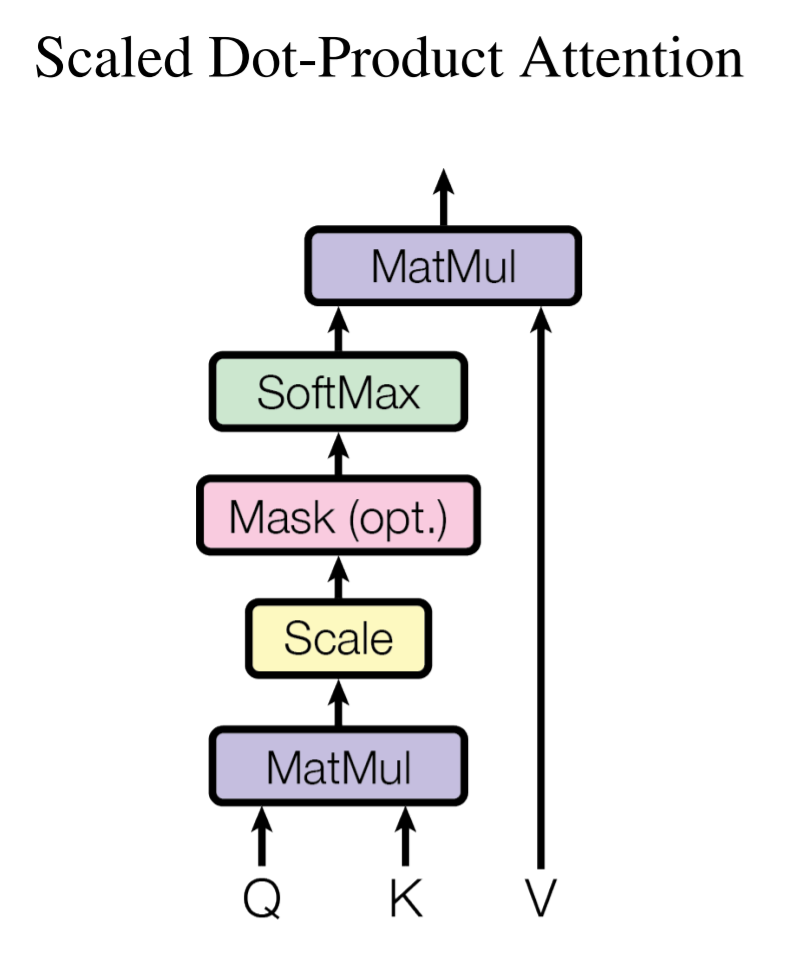

In [12]:
from IPython.display import Image
Image('scaled_dot_attention.PNG', width=425, height=500)

For those of us who learn by scanning the raw code of the algorithm, here is a PyTorch implementation of Scaled Dot-Product Attention:

In [0]:
from enum import IntEnum
class Dim(IntEnum):
    batch = 0
    seq = 1
    feature = 2

class ScaledDotProductAttention(nn.Module):
    def __init__(self, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        
        def forward(self, q, k, v, mask=None):
        # gets the key size
        d_k = k.size(-1) 
        assert q.size(-1) == d_k
        
        # computes the dot product between queries and 
        # keys for each batch and position in sequence
        attn = torch.bmm(q, k.transpose(Dim.seq, Dim.feature)) # (Batch, Seq, Seq)
        # an attention score between each position 
        # in the sequence for each batch is given.
        
        # scale the dot products by the dimensionality
        attn = attn / math.sqrt(d_k)
        # weight normalization across sequence dimension
        attn = torch.exp(attn)
        # fill attention weights with 0s where padded
        if mask is not None: attn = attn.masked_fill(mask, 0)
        attn = attn / attn.sum(-1, keepdim=True)
        attn = self.dropout(attn)
        output = torch.bmm(attn, v) # (Batch, Seq, Feature)
        return output

### 2.1.2 Multi-Head Attention
The second sub-layer of the encoder refrains from performing a single attention function, and instead linearly projects the queries, keys, and values *h* times with different, learned linear projections to the query dimensions, key dimensions, and value dimensions. Each of these linear projections are then subject to the attention function in parallel, the yielded dimensional output values are then concatenated and projected once again, resulting in the final values. 

This is the magic of the Transformer model. Multi-Head attention allows the model to jointly attend to information from different representation subspaces at different positions.

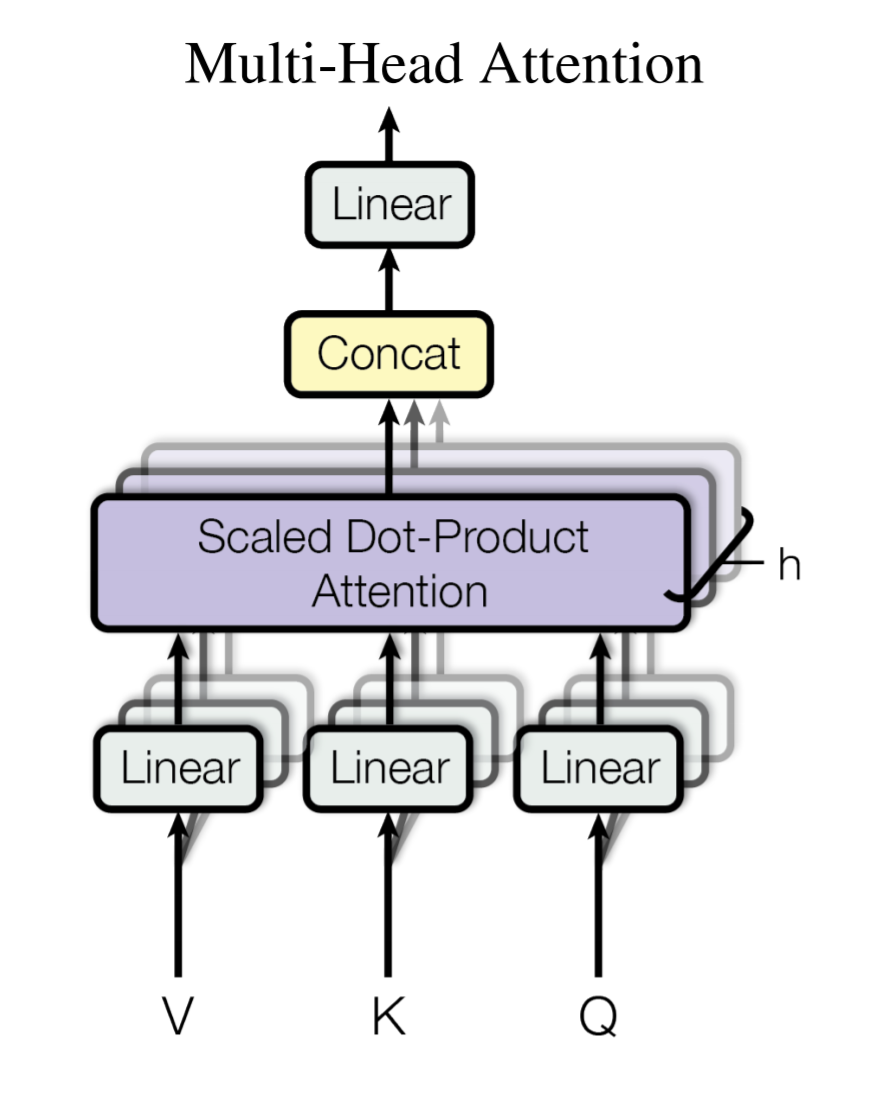

In [10]:
from IPython.display import Image
Image('multi_head_attention.PNG', width=425, height=500)

And now, once again, the raw algorithmic code, for those of us who'd enjoy a peek:

In [0]:
class AttentionHead(nn.Module):
    """A single attention head"""
    def __init__(self, d_model, d_feature, dropout=0.1):
        super().__init__()
        # We will assume the queries, keys, and values all have the same feature size
        self.attn = ScaledDotProductAttention(dropout)
        self.query_tfm = nn.Linear(d_model, d_feature)
        self.key_tfm = nn.Linear(d_model, d_feature)
        self.value_tfm = nn.Linear(d_model, d_feature)
        
    def forward(self, queries, keys, values, mask=None):
        # (Batch, Seq, Feature)
        Q = self.query_tfm(queries)
        # (Batch, Seq, Feature)
        K = self.key_tfm(keys) 
        # (Batch, Seq, Feature)
        V = self.value_tfm(values)
        # compute multiple attention weighted sums
        x = self.attn(Q, K, V)
        return x

class MultiHeadAttention(nn.Module):
    """The full multihead attention block"""
    def __init__(self, d_model, d_feature, n_heads, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.d_feature = d_feature
        self.n_heads = n_heads
        # in practice, d_model == d_feature * n_heads
        assert d_model == d_feature * n_heads
        
        # Note that this is very inefficient:
        # separate implementation of heads is
        # used here because it is easily understood. 
        self.attn_heads = nn.ModuleList([
            AttentionHead(d_model, d_feature, dropout) for _ in range(n_heads)
        ])
        self.projection = nn.Linear(d_feature * n_heads, d_model) 
        
    def forward(self, queries, keys, values, mask=None):
        log_size(queries, "Input queries")
        x = [attn(queries, keys, values, mask=mask)
              # (Batch, Seq, Feature)
             for i, attn in enumerate(self.attn_heads)]
         
        # reconcatenatation of ouput dimensional values
        # (Batch, Seq, D_Feature * n_heads)
        x = torch.cat(x, dim=Dim.feature)
        log_size(x, "concatenated output")
        # (Batch, Seq, D_Model)
        x = self.projection(x)
        return x

## 2.2 Decoder
The decoder architecture is very similar to the encoder. The encoder starts by processing the input sequence. The output of the top encoder is then transformed into a set of attention vectors *K* and *V*. These vectors are used by each decoder in its *encoder-decoder attention* layer, which helps the decoder focus on appropriate places in the input sequence. These steps are repeated until a special symbol is reached. The special symbol indicates the Transformer decoder has completed its output. The ouput of each step is fed to the bottom decoder in the next time step, and the decoders bubble up their decoding results in the same manner as the encoders have. Just as the encoder inputs have done, the decoder inputs embed and add encoding to indicate position.

Along with the Scaled Dot-Product and Multi-Head sub-layers in each encoder layer, and the residual connections around each of the sub-layers, followed by layer normalization, the decoder employs an additional third sub-layer. This additional layer masks multi-head attention over the output of the encoder stack. Like the encoder, the decoder includes residual connections and layer normalization. The self-attention sub-layer of the decoder stack is also modified to prevent positions from attending to subsequent positions, ensuring the predictions for a position depend only on known outputs at positions less than it.

---



## 2.3 Self-Attention
A concept largely used in the Transformer model is known as Self-Attention. Let's see how it works. Say we have the following input sentence, and want to translate it:

"The animal didn't cross the street because it was too tired"

When the model is processing the word "it" self-attention allows it to associate "it" with "animal". As the model processes each word, self-attention allows it to look at other positions in the input sequence, either ahead or behind the current position, for clues that can help lead to a better encoding for the word. 

The first step in calculating self-attention is to create three vectors from each of the encoder's input vectors, which, in this case, is the embedding of each word. For each word, we create a Query vector, a Key vector, and a Value vector.

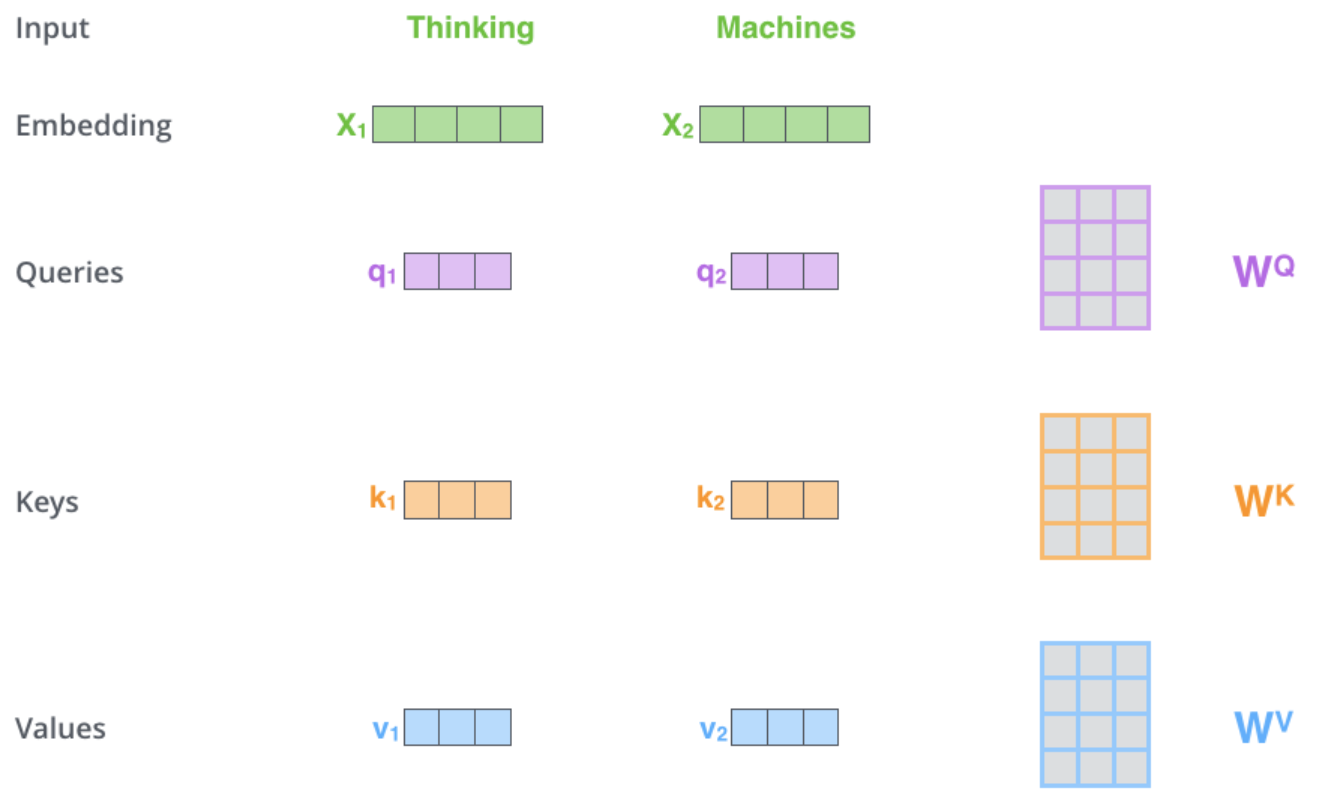

In [45]:
from IPython.display import Image
Image('self_attention_one.PNG', width=800, height=425)

The query, key, and value vectors are abstractions that are useful for calculating and thinking about attention. The second step is to calculate a self-attention score. This mean scoring each word of the input sequence against, say, the first word in the example "Thinking". The score determines how much focus, or attention, to place on other parts of the input sequence as we encode a word at a certain position. 

The score is calculated by taking the dot product of the query vector with the key vector of the respective word we're scoring.

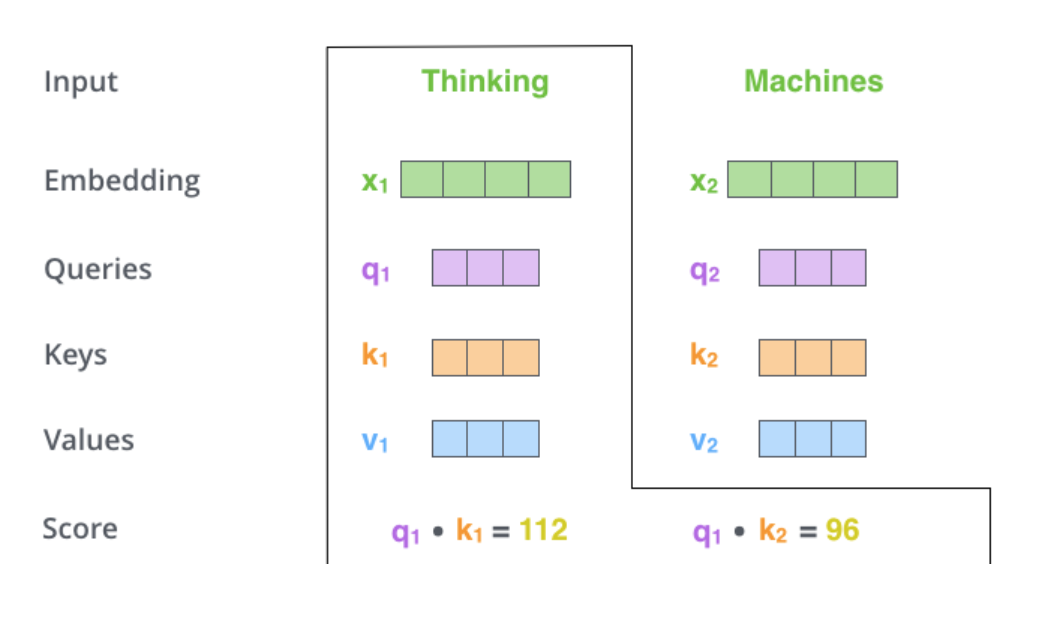

In [47]:
from IPython.display import Image
Image('self_attention_two.PNG', width=800, height=425)

Next, we divide the scores by the square root of the dimension of the key vectors used, leading to having more stable gradients. Then we pass the result through a softmax operation to normalize the scores so they're all positive and all add up to 1. The softmax score determines how much each word will be expressed at this position.

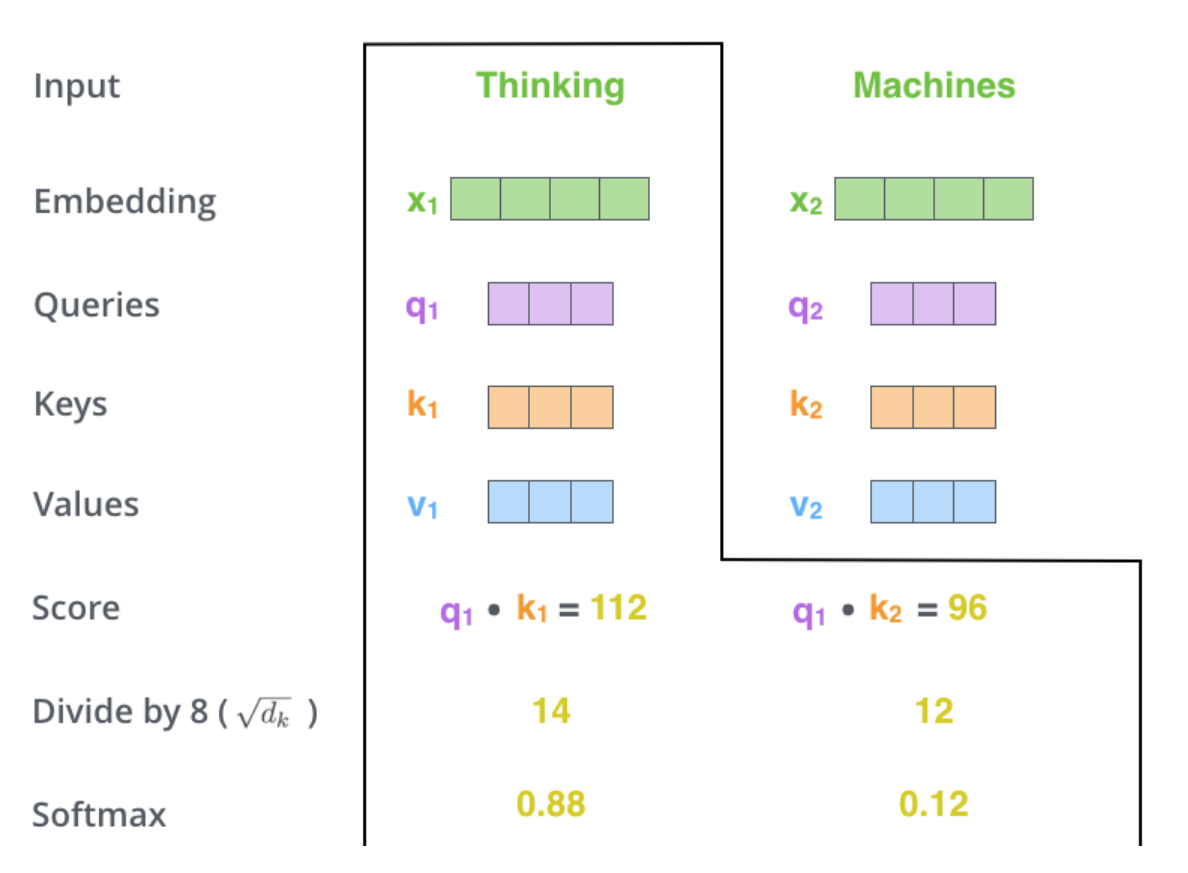

In [52]:
from IPython.display import Image
Image('self_attention_three.PNG', width=800, height=500)

The next step is to multiply each value vector by the softmax score in preperation to sum them up to keep intact the values of the word(s) we want to focus on, and drown-out the irrelevant words. Then we sum up the weighted value vectors, which produces the output of the self-attention layer at this position. 

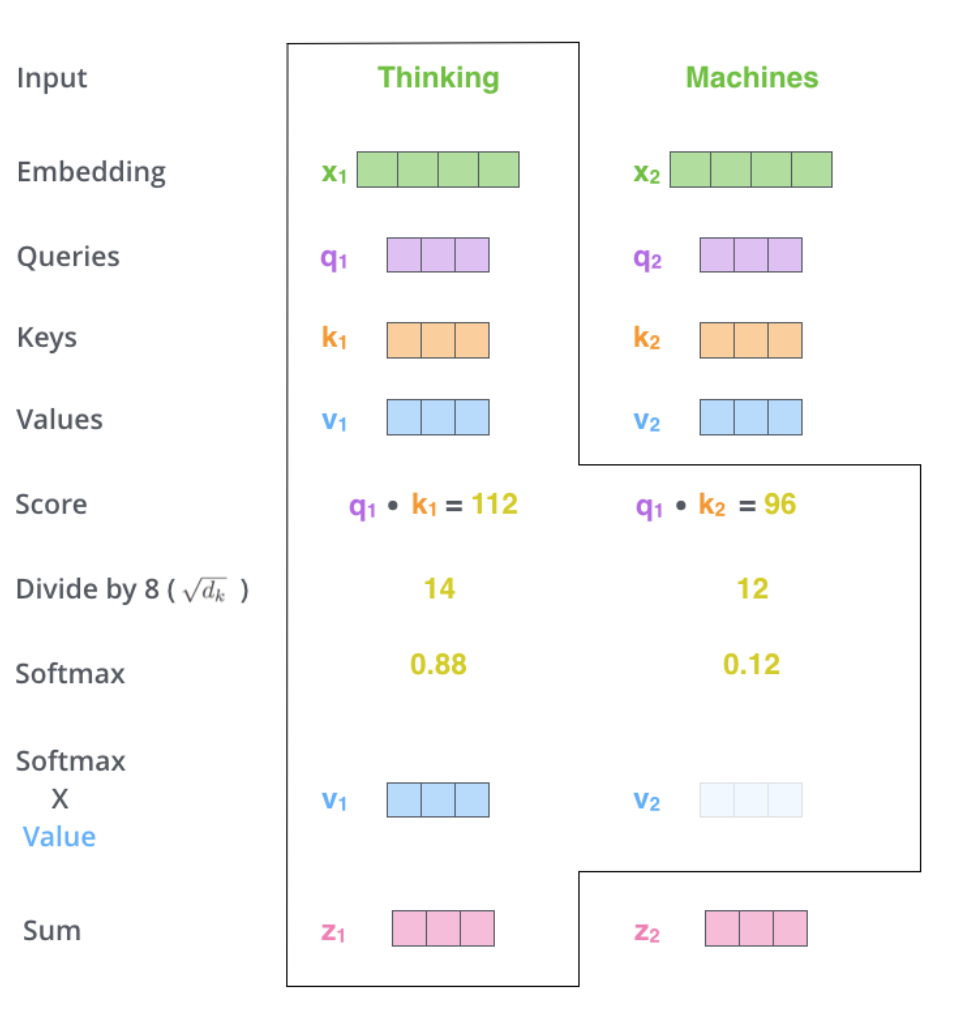

In [56]:
from IPython.display import Image
Image('self_attention_four.PNG', width=800, height=750)

That is the self-attention calculation, and the resulting vector is one we can send along to the feed-forward neural network. 

## 3 Training

---

## 3.1 Training Example

To exemplify the Transformer model, we will compare its output with the actual correct output, training on a labeled training dataset on a language translation problem. Let's assume our output vocabulary only contains six words, i.e.

1.   a
2.   am
3.   i
4.   thanks
5.   student
6.   eos (end of sentence)

Once the output vocabulary is defined, we use a vector of the same width to indicate each word in the vocabulary in a process known as one-hot encoding. For instance, we indicate the word "am" using the following vector:


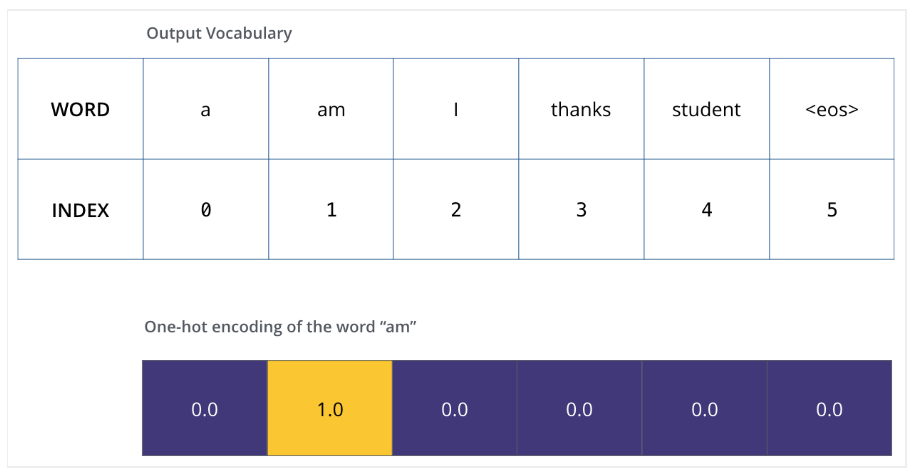

In [27]:
from IPython.display import Image
Image('output_vocabulary.PNG', width=800, height=375)

So let's say we're training our Transformer on a simple example, translating "merci" to "thanks". That means we want the output to be a probability distribution indicating the word "thanks". Since our model is untrained, that's probably not going to be the case, yet, since the model's weights are all initialized randomly. What our model will produce is a probability distribution with arbitrary values for each word. But we can take this and compare it with the actual output, then tweak the weights of our model using backpropogation to make the ouput closer to the desired output.

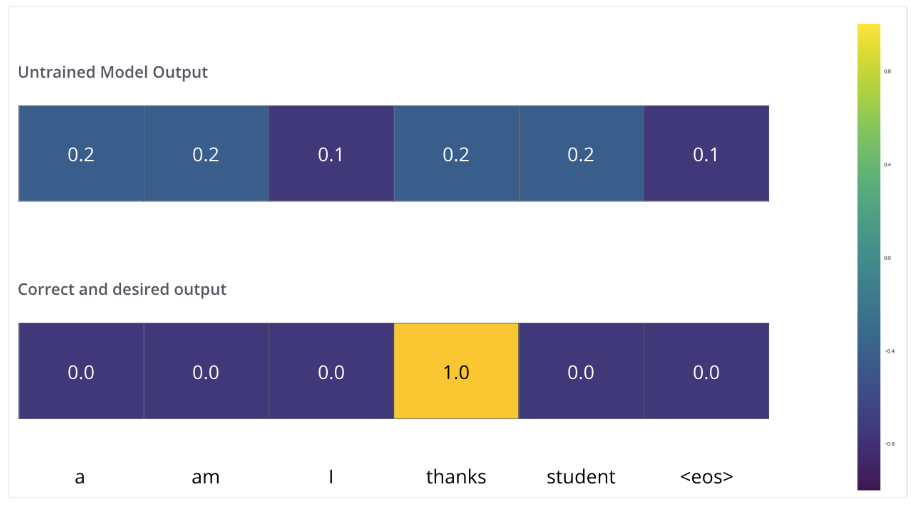

In [28]:
from IPython.display import Image
Image('model_output.PNG', width=800, height=375)

More realistically, we'll use a sentence longer than one word, i.e. the input "je suis etudiant" with expected output "i am a student" which means we want our model to successively output probability distributions where each probability distribution is represented by a vector of width vocab_size 6, where the first probability distribution has the highest probability at the cell associated with the word "i", where the second probability distribution has the highest probability at the cell associated with the word "am", and so on until the "end of sentence" output distribution. These target model outputs can be seen below:

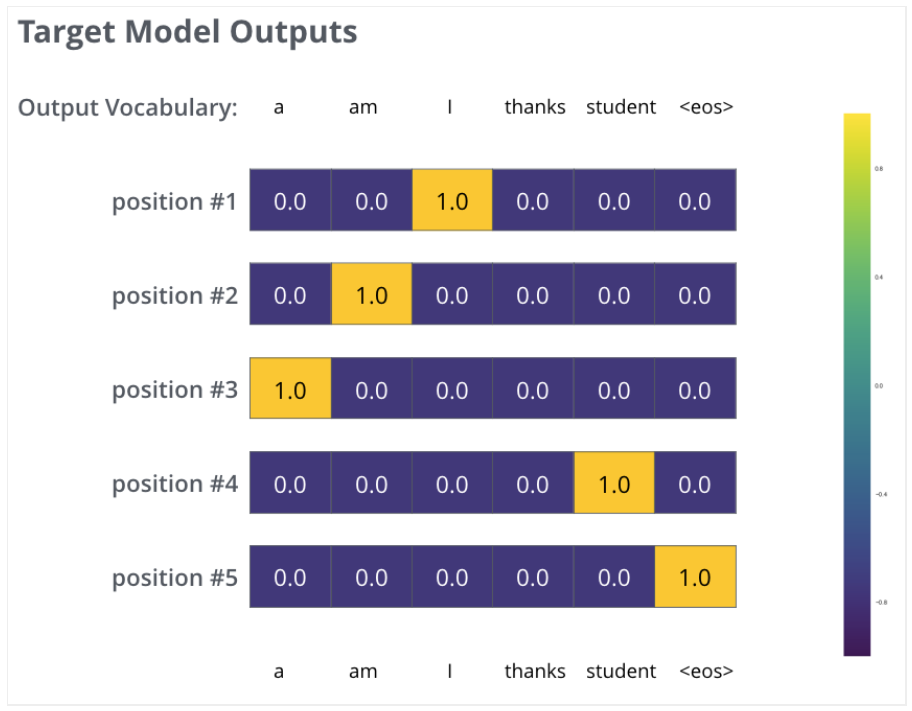

In [34]:
from IPython.display import Image
Image('target_outputs.PNG', width=800, height=550)

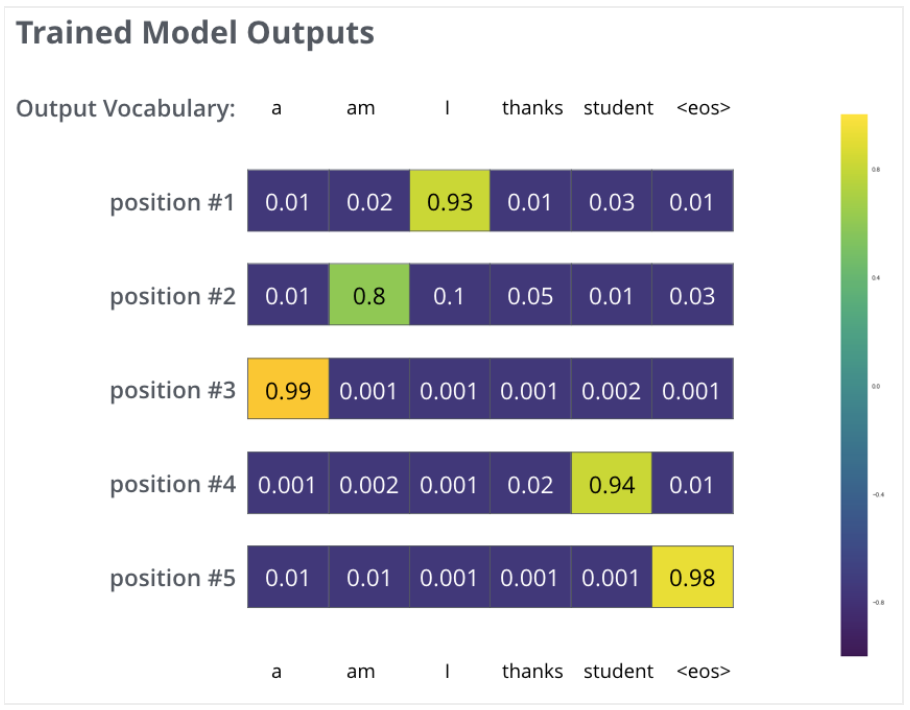

In [35]:
from IPython.display import Image
Image('hoped_outputs.PNG', width=800, height=550)

Because the model produces the outputs one at a time, we assume that the model is selecting the word with the highest probability from that probability distribution and throwing away the rest. That would be the greedy decoding way of doing things. 

Another way would be to hold on to, say, the top two words, then in the next step, run the model twice, once assuming the first output position was the word "i", and another time assuming the first output was the word "me", and whichever version produced less error considering both positions, is kept. This method is called beam search.

---

## 3.2 Training From Research Paper
In Attention Is All You Need, training is done on the standard WMT 2014 English-German dataset, which contains some 4.5 million sentence pairs. A significantly larger dataset is used for the English-French training, namely the WMT 2014 English-French dataset consisting of 36 million sentences. Each training batch contained a set of sentence pairs of ~25,000 source tokens and ~25,000 target tokens. The training was done on one machine with 8 NVIDIA P100 GPUs. Each training step took ~0.4 seconds. The base models were trained for a total of 100,000 steps or 12 hours. The big models were trained for 300,000 steps or 3.5 days. Adam was the optimizer. Residual Dropout was introduced as regularization to the output of each sub-layer before it was added to the sub-layer input and normalized. Dropout was also applied to the sums of the embeddings and the positional encodings in both the encoder and decoder stacks. The results can be seen in the table below:

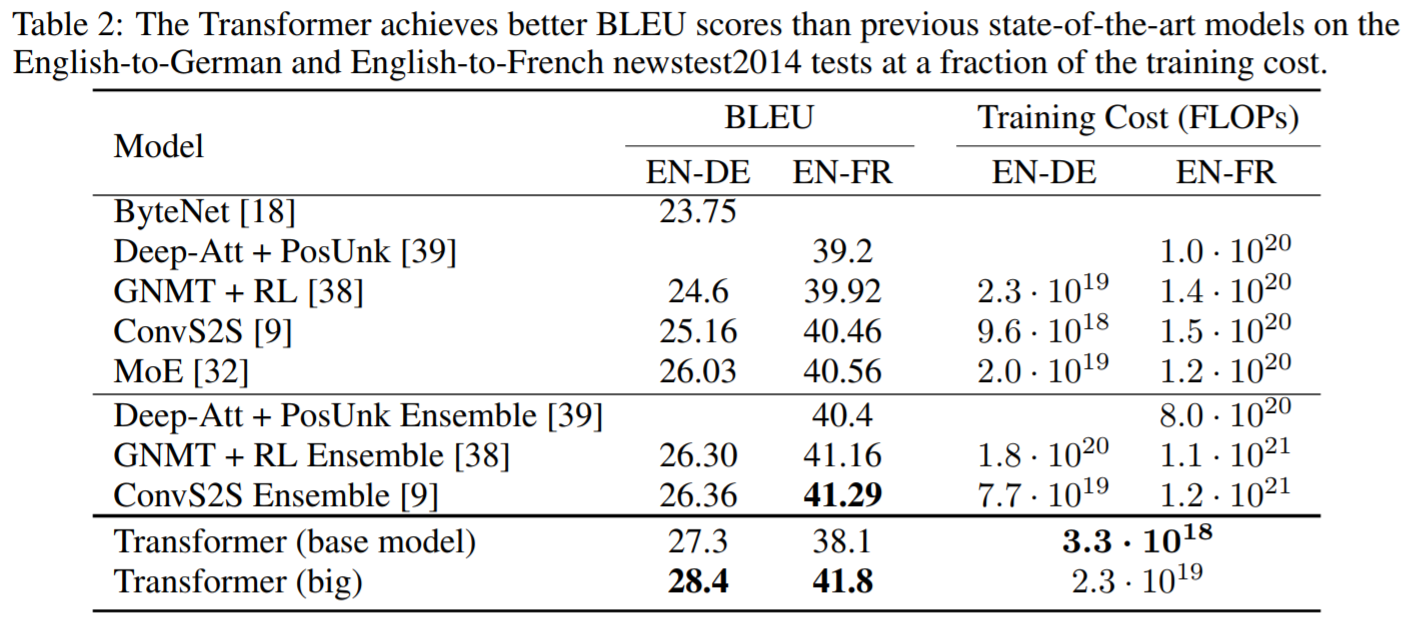

In [39]:
from IPython.display import Image
Image('results.PNG', width=800, height=375)

Let's see what these mean. In a nutshell, the Transformer achieves state-of-the-art BLEU scores at a fraction of the training cost. BLEU, or the Billingual Evaluation Understudy, is a score for comparing a candidate translation of text to one or more reference translations. For example:

In [40]:
from nltk.translate.bleu_score import sentence_bleu
reference = [['the', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog']]
candidate = ['the', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog', 'from', 'space']
score = sentence_bleu(reference, candidate)
print(score)

0.7860753021519787


The score here is something like two words wrong, which can be seen as correct from the two sentences given above as data. So a higher BLEU score means a better model. From the results in the table above, we can see both Transformer models proposed outperform the previous state-of-the-art models for language translation. Not only that, but the training costs are lowered substantialy from the previous models to the Transformer models, making the Transformer a win-win.

---

## Conclusion
The Transformer is the first sequence transduction model based entirely on attention, replacing the recurrent layers most commonly used in encoder-decoder architectures with multi-headed self-attention. 

Work has been done with Transformer model applied to tasks outside of language translation alone. For example, Google has taken the model and ran it on music generation tasks, results of which are astonishing and can be linked to be clicking the following: https://magenta.tensorflow.org/music-transformer.

What is most notable, is the Transformer's ability to generate with long-term structure, meaning the model, when used with relative attention, explicitly modulates attention based on how far apart tokens are, making it able to focus more on relational features. This model is gaining attention with it's results as it generates sophisticated music based on given motifs that contain musical structure and achieve state-of-the-art results.

And that's not it. The Transfomer can be applied to text-generation to create stories with long-term structure, an important quality of cohesive literature. All in all, the Transformer model is redefining the process sequencing for the better. 